# Test fine-tuned Llamantino model

In [ ]:
## Imports

In [19]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, Dataset
from datetime import datetime
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                             ConfusionMatrixDisplay)

In [3]:
test_set_name = "sample_data/test_isear_it.csv"

# 0 gioia
# 1 tristezza
# 2 rabbia
# 3 paura
# 4 vergogna
# 5 disgusto
# 6 colpevolezza
sentiments = ["gioia", "tristezza", "rabbia", "paura", "vergogna", "disgusto", "colpevolezza", "None"]

## Dataset splits loading

In [7]:
df = pd.read_csv(test_set_name, delimiter="|")
test_set = Dataset.from_pandas(df)

In [4]:
test_set[0]

{'text': 'Da bambino - essere mandato al negozio dalla mamma - comprare del cioccolato - essere ripreso dalla mamma.',
 'label': 4}

## Load fine-tuned model

In [5]:
model_name = "llama-2-7b-emotions-final"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following function returns a pipeline for text generation with a different max_new_tokens parameter according to the user input length:

In [8]:
def get_llama_pipeline(question_length):
    return pipeline(
        "text-generation",
        tokenizer=tokenizer,
        model=model,
        max_new_tokens=question_length if question_length < 500 else 500,
        device_map={"": 0}
    )

The following function uses the pipeline to generate the output:

In [9]:
def llama_chat(prompt, llama_pipeline, system_prompt=""):
    formatted_prompt = "<s>[INST]<<SYS>>\n" \
         "Sei un assistente disponibile, rispettoso e onesto. " \
         "Riconosci quale sentimento esprime la frase che ti viene posta\n" \
         "<</SYS>>\n\n" \
         f"{prompt}[/INST]</s>"
    sequences = llama_pipeline(
        formatted_prompt,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        return_full_text=False
    )
    return sequences[0]["generated_text"]

Since the pipeline generates a very poor quality output, the following function detects the presence of the most frequent sentiment in the output and returns it:

In [10]:
def detect_sentiment(answer):
    max_count = 0
    detected_sentiment = None
    for sentiment in sentiments:
        c = answer.count(sentiment)
        if c > max_count:
            max_count = c
            detected_sentiment = sentiment

    return detected_sentiment

## Metrics calculation

Now calculate predicted sentiments for each example of the test set:

In [ ]:
start = datetime.now()
y_pred = list()
counter = 0
for i, example in df.iterrows():
    i += 1
    print("Example", i)
    user_input = example["text"]
    print("User:", user_input)
    answer = llama_chat(user_input, get_llama_pipeline(len(example["text"])))
    print("Chatbot:", answer.strip(), "\n")
    sentiment = detect_sentiment(answer)
    y_pred.append(sentiment)
    print("Detected emotion:", sentiment)
    print("Real emotion:", sentiments[example["label"]])
    if sentiment == sentiments[example["label"]]:
        counter += 1
    print(f"Correct predictions: {counter}/{test_set.num_rows}\n")
end = datetime.now()
print("Elapsed time:", end-start)

In [9]:
y_pred = ['None' if i is None else i for i in y_pred]  # Make None elements as string
labels_pred = [sentiments.index(i) for i in y_pred]  # Get the string sentiment according to the id
print(len(test_set["label"]))
accuracy = accuracy_score(y_true=test_set["label"], y_pred=labels_pred)
print(f"Accuracy score: {accuracy}")

1128
Accuracy score: 0.4858156028368794


In [11]:
class_report = classification_report(y_true=test_set["label"], y_pred=labels_pred)
print("Classification report:")
print(class_report)

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       164
           1       0.62      0.48      0.54       162
           2       0.36      0.44      0.40       162
           3       0.80      0.49      0.61       162
           4       0.33      0.52      0.40       161
           5       0.52      0.51      0.51       160
           6       0.39      0.32      0.35       157
           7       0.00      0.00      0.00         0

    accuracy                           0.49      1128
   macro avg       0.48      0.42      0.44      1128
weighted avg       0.54      0.49      0.50      1128



Confusion matrix:
[[103   9  12   7  20   1   8   4]
 [  3  77  23   1  27  14   8   9]
 [  2   6  72   4  27  31  16   4]
 [ 10  13  15  80  15  14   7   8]
 [  6   4  23   3  83  11  28   3]
 [  5   6  26   3  22  82  13   3]
 [  1  10  31   2  55   6  51   1]
 [  0   0   0   0   0   0   0   0]]


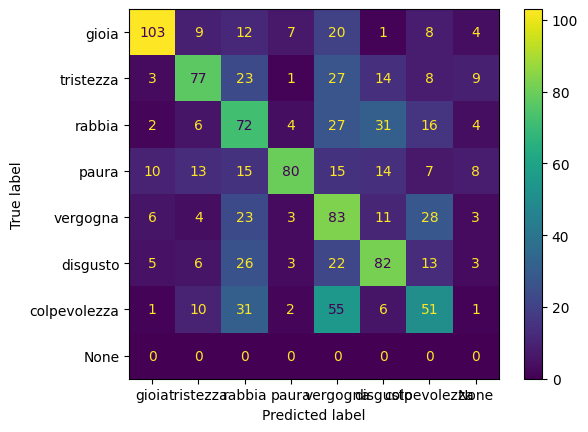

In [23]:
conf_matrix = confusion_matrix(y_true=test_set["label"], y_pred=labels_pred)
print("Confusion matrix:")
print(conf_matrix)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sentiments).plot()
plt.show()